In [28]:
import math
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [29]:
SCENE_PATH = Path("../blender-scenes/complex-logistics-yard-truck-scene/")
CAMERA_MATRIX_LOCATION = SCENE_PATH / Path("output/camera_matrices/")


# Load the camera matrices
world_to_orthographic_ndc = np.load(CAMERA_MATRIX_LOCATION / Path("matrix_world_to_orthographic_ndc.npy"))
ndc_to_pixels = np.load(CAMERA_MATRIX_LOCATION / Path("matrix_ndc_to_pixels.npy"))

image_top_down = cv2.imread("../assets/images/Camera_TopDown_ImageRGB_blank.png")
camera_icon_path = "../assets/images/camera-icon.png"
output_path = "../assets/images/Camera_TopDown_overview_graphic.png"

In [30]:
# find all the camera matrices in CAMERA_MATRIX_LOCATION from pattern "matrix_{camera_name}_world_position"
camera_coordinates: dict[str, np.ndarray] = {}
camera_rotations: dict[str, np.ndarray] = {}
for file in CAMERA_MATRIX_LOCATION.iterdir():
    if file.is_file() and file.name.startswith("matrix_") and file.name.endswith("_world_position.npy"):
        camera_name = file.name.replace("matrix_", "").replace("_world_position.npy", "")
        world_pos = np.load(file)

        # Apply the transformations to convert world coordinates to pixel coordinates
        ndc_pos = world_to_orthographic_ndc @ world_pos
        pixel_pos = ndc_to_pixels @ ndc_pos

        camera_coordinates[camera_name] = pixel_pos
        camera_rotations[camera_name] = np.load(CAMERA_MATRIX_LOCATION / Path(f"matrix_{camera_name}_world_rotation.npy"))

assert len(camera_coordinates) > 0, "No camera matrices found"
assert len(camera_coordinates) == len(camera_rotations), "Camera coordinates and orientations should be the same length"
assert all(len(camera_coordinates[camera_name]) == 4 for camera_name in camera_coordinates), "Camera coordinates should be 4D"
assert all(len(camera_rotations[camera_name]) == 3 for camera_name in camera_rotations), "Camera orientations should be 3D"
print(f"Loaded {len(camera_coordinates)} camera matrices")

Loaded 8 camera matrices


In [31]:
def plot_camera_icon(image: np.ndarray, camera_icon: np.ndarray, pixel_coords: np.ndarray, z_rot: float) -> np.ndarray:
    """Draws the camera icon on the given image with the specified pixel coordinates and rotation.

    Args:
        image (numpy.ndarray): The image onto which the camera icon is drawn.
        camera_icon (numpy.ndarray): The image of the camera icon.
        pixel_coords (numpy.ndarray): The pixel coordinates of the camera.
        z_rot (float): The rotation of the camera around the z-axis in degrees.

    Returns:
        numpy.ndarray: A copy of the image with the camera icon drawn.
    """
    # Calculate the position of the camera icon in the image    
    top_left_x = int(pixel_coords[0]) - 25
    top_left_y = int(pixel_coords[1]) - 25
    bottom_right_x = int(pixel_coords[0]) + 25
    bottom_right_y = int(pixel_coords[1]) + 25

    # Check if the camera icon is within the bounds of the image
    if (
            top_left_x < 0
            or top_left_y < 0
            or bottom_right_x > image.shape[1]
            or bottom_right_y > image.shape[0]
    ):
        print("Skip camera icon drawing, out of bounds")
        return image

    # Rotate the camera icon
    rows, cols, _ = camera_icon.shape
    rot_mat = cv2.getRotationMatrix2D((cols / 2, rows / 2), z_rot + 90, 1)
    camera_icon = cv2.warpAffine(camera_icon, rot_mat, (cols, rows))

    # Add the camera icon to the image. Consider the alpha channel of the icon
    image_c = image.copy()
    for c in range(0, 3):
        image_c[top_left_y:bottom_right_y, top_left_x:bottom_right_x, c] = camera_icon[:, :, c] * (
                camera_icon[:, :, 3] / 255.0
        ) + image_c[top_left_y:bottom_right_y, top_left_x:bottom_right_x, c] * (
                                                                                 1.0 - camera_icon[:, :, 3] / 255.0
                                                                         )

    return image_c

def draw_cameras(image: np.ndarray, camera_pixel_coordinates: dict[str, np.ndarray], camera_orientations: dict[str, np.ndarray], camera_icon_path: str, fov: int) -> np.ndarray:
    """Draws the cameras on the image with the field of view (FOV) triangles.

    Args:
        image (numpy.ndarray): The image onto which the cameras are drawn.
        camera_pixel_coordinates (dict): A dictionary containing the pixel coordinates of the cameras.
        camera_orientations (dict): A dictionary containing the XYZ-rotations of the cameras.
        camera_icon_path (str): The path to the camera icon image.
        fov (int): The field of view (FOV) for the cameras.

    Returns:
        numpy.ndarray: The image with the drawn cameras and FOV triangles.
    """
    # load the camera icon as unchanged to keep the alpha channel
    camera_icon: np.ndarray = cv2.imread(camera_icon_path, cv2.IMREAD_UNCHANGED)


    for camera_name, pixel_coords in camera_pixel_coordinates.items():

        # plot the camera icon on the image
        z_rot = camera_orientations[camera_name][2]
        
        print(f"Camera {camera_name} - Position: {pixel_coords} - Rotation: {z_rot}")

        image = draw_fov_triangle(image, pixel_coords, z_rot, fov)
        image = plot_camera_icon(image, camera_icon, pixel_coords, z_rot)

    return image

def _draw_circle_with_alpha_blend(radius: float, shape: tuple, midpoint: tuple) -> np.ndarray:
    """Draws a circle with an alpha blend effect.

    Args:
        radius (float): The radius of the circle.
        shape (tuple): The shape of the output image (height, width).
        midpoint (tuple): The coordinates of the circle's center.

    Returns:
        numpy.ndarray: An image with the drawn circle and alpha blend effect.

    """
    x = np.arange(shape[1])
    y = np.arange(shape[0])
    xx, yy = np.meshgrid(x, y)

    # Calculate distance from each point to the center
    distance = np.sqrt((xx - midpoint[1])**2 + (yy - midpoint[0])**2)

    # Normalize distance to range [0, 1]
    normalized_distance = distance / radius
    normalized_distance[normalized_distance > 1] = 1  # Clip values greater than 1

    # Map normalized distance to alpha values (from 1 to 0)
    alpha_values = 1 - normalized_distance

    # Create RGBA tensor with fading circle
    rgba_tensor = np.zeros((*shape, 4), dtype=np.float32)
    rgba_tensor[:,:,0] = 1  # Red channel
    rgba_tensor[:,:,1] = 1  # Green channel
    rgba_tensor[:,:,2] = 1  # Blue channel
    rgba_tensor[:,:,3] = alpha_values  # Alpha channel

    return rgba_tensor

def draw_fov_triangle(image: np.ndarray, pixel_coords: np.ndarray, z_rot: float, fov: float, fov_distance: float=350) -> np.ndarray:
    """Draws the FOV triangle for a camera on an image.

    Args:
        image (numpy.ndarray): The image onto which the FOV triangle is drawn.
        pixel_coords (numpy.ndarray): The pixel coordinates of the camera.
        z_rot (float): The rotation of the camera around the z-axis.
        fov (float): The field of view (FOV) for the camera.
        fov_distance (float, optional): The distance for the FOV triangle. Default is 350.

    Returns:
        numpy.ndarray: The image with the drawn FOV triangle.
    """
    z_rot_rad = math.radians(-z_rot+270)

    # Calculate the points of the triangle relative to the center
    fov_rad_half = math.radians(fov / 2)
    dx1 = fov_distance * math.cos(z_rot_rad + fov_rad_half)
    dy1 = fov_distance * math.sin(z_rot_rad + fov_rad_half)
    dx2 = fov_distance * math.cos(z_rot_rad - fov_rad_half)
    dy2 = fov_distance * math.sin(z_rot_rad - fov_rad_half)

    # Midpoint of the camera
    cx, cy = int(pixel_coords[0]), int(pixel_coords[1])

    # Points for the triangle before rotation
    points = np.array([
        [cx, cy],
        [cx + dx1, cy + dy1],
        [cx + dx2, cy + dy2]
    ])

    # draw transparent triangles
    triangle = np.zeros_like(image)
    cv2.fillPoly(triangle, [points.astype(np.int32)], color=(51, 230, 230))

    # add alpha channel to the triangle and normalize the values to [0, 1]
    triangle = np.dstack([triangle, np.full(triangle.shape[:2], 255)]).astype(np.float32) / 255

    # Create a circular mask
    fade_mask = _draw_circle_with_alpha_blend(fov_distance*0.75, triangle.shape[:2], (cy,cx))
    # cut the fade_mask to have alpha values of 1 everywhere outside the triangle
    fade_mask_alpha = fade_mask[:,:,3]
    fade_mask_alpha_cut = fade_mask_alpha * (triangle[:,:,0] != 0)

    # use the RGB channels from the triangle and the alpha channel from the fade mask
    triangle_with_alpha = np.zeros((*triangle.shape[:2], 4), dtype=np.float32)
    triangle_with_alpha[:,:,:3] = triangle[:,:,:3]
    triangle_with_alpha[:,:,3] = (fade_mask_alpha_cut).astype(np.float32)
    
    # Blend the fading triangle with the image using alpha blending
    final_image = (triangle_with_alpha[..., :3] * triangle_with_alpha[..., 3:] * 255 +
                image * (1 - triangle_with_alpha[..., 3:])).astype(np.uint8)

    return final_image

Camera Camera_Gates_Left - Position: [463.4245   362.6812    42.315903   1.      ] - Rotation: -60.0


Camera Camera_Building_Right - Position: [1.5646182e+03 2.1827728e+02 3.4871696e+01 1.0000000e+00] - Rotation: 125.0
Camera Camera_Building_Left - Position: [432.86237  218.27728   34.871696   1.      ] - Rotation: 240.0
Camera Camera_Opposite_Building_1 - Position: [496.10437  841.43835   35.021698   1.      ] - Rotation: 330.0
Camera Camera_Opposite_Building_2 - Position: [1.1166720e+03 8.5105237e+02 3.5021698e+01 1.0000000e+00] - Rotation: 345.0
Camera Camera_Gates_Left_2 - Position: [428.64514  245.11725   44.954376   1.      ] - Rotation: -108.00000762939453
Camera Camera_Gates_Right - Position: [1.4843851e+03 3.6268121e+02 4.2315903e+01 1.0000000e+00] - Rotation: 59.0
Camera Camera_Entrance_Right - Position: [1.4910575e+03 3.6813098e+02 4.2315903e+01 1.0000000e+00] - Rotation: 220.0


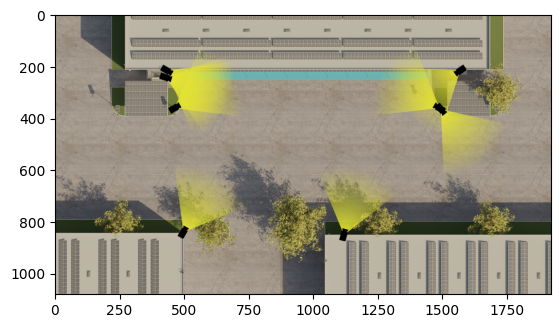

In [32]:
final_image = draw_cameras(image_top_down, camera_coordinates, camera_rotations, camera_icon_path, fov=75)
cv2.imwrite(output_path, final_image)

plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.show()